### Efficient Frontier

In [1]:
from efficient_frontier import efficient_frontier

c:\Users\camil\efficient-frontier\efficient_frontier.py:150: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('', np.nan)
c:\Users\camil\efficient-frontier\efficient_frontier.py:150: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('', np.nan)


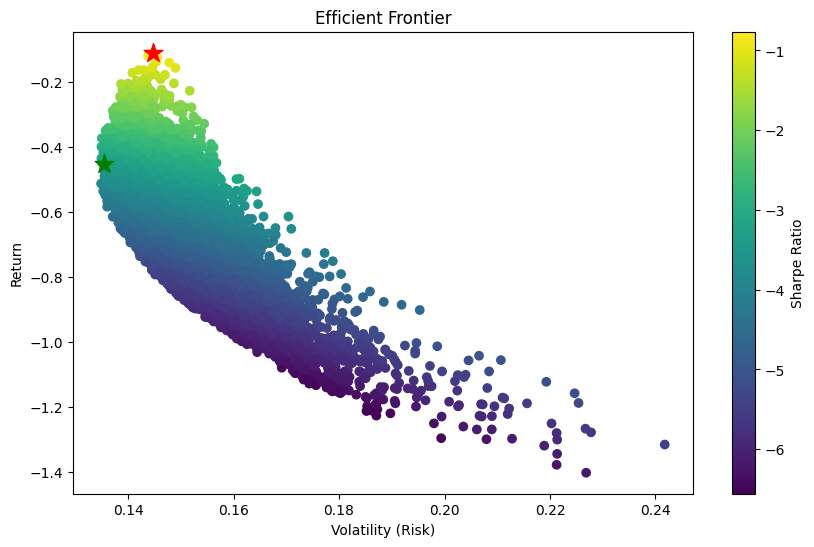

Optimal Portfolio Stats: 


,Return,Volatility,Sharpe
0,-1.084113,0.173705,-6.241103


Max volatility and return: 0.14469708945100107, -0.11078716358551037

Min volatility and return: 0.1355101076285019, -0.4543103412055033

Stats: 


,apple,google,facebook,microsoft,amazon
expected_return,-0.006626,-0.000094,-0.004080,-0.002775,-0.000149
variance,0.000387,0.000105,0.000189,0.000135,0.000104
standard_deviation,0.019667,0.010270,0.013751,0.011605,0.010206
variation_coefficient,-2.968167,-108.924217,-3.370277,-4.181692,-68.539624
performance,-0.336908,-0.009181,-0.296712,-0.239138,-0.014590
sharpe_index,-2.879256,-4.877501,-3.932911,-4.547521,-4.913774
beta,1.434864,1.193072,1.560259,1.594026,0.352515
n,19.000000,19.000000,19.000000,19.000000,19.000000


Weights applied on each portfolio: 


,Companies,Weights
0,Apple,35.75%
1,Google,3.36%
2,Facebook,25.16%
3,Microsoft,32.39%
4,Amazon,3.35%


In [2]:
# List of URLs where the S&P500 must be the first one, cause it will be compared with the rest of the portfolio
urls = ['https://investing.com/indices/us-spx-500-historical-data',
        'https://www.investing.com/equities/apple-computer-inc-historical-data', 
        'https://www.investing.com/equities/google-inc-c-historical-data',
        'https://www.investing.com/equities/facebook-inc-historical-data',
        'https://www.investing.com/equities/microsoft-corp-historical-data',
        'https://www.investing.com/equities/amazon-com-inc-historical-data']

efficient_frontier(urls, 0.05)